In [1]:
import os
import gc
import numpy as np
import pandas as pd
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Functional, Model
from keras.layers import Input, Conv1D, Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam, Adamax
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import csv

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-05 09:35:53.035169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set precision to two decimals
pd.set_option("display.precision", 2)

# Charts inline
%matplotlib inline

In [3]:
path = '../child-mind-institute-detect-sleep-states/'
NBR_SAMPLES = 269 # <-- use the number of samples from DataCleaning


csv_file_path = path +f'selected_series_{NBR_SAMPLES}.csv'
with open(csv_file_path, 'r') as csv_file:
    selected_series = list(csv.reader(csv_file))[0]
NBR_SAMPLES

269

In [4]:
print('Reading files.....')
train_merged = pd.read_parquet(path + f'train_merged_{NBR_SAMPLES}.parquet')
test_series = pd.read_parquet(path + 'test_series.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
print('..... done!')

Reading files.....
..... done!


In [5]:
train_merged

,series_id,step,timestamp,anglez,enmo,night,event
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.64,0.02,NaN,None
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.64,0.02,NaN,None
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.64,0.02,NaN,None
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.64,0.02,NaN,None
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.64,0.02,NaN,None
...,...,...,...,...,...,...,...
124822075,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.28,0.02,NaN,None
124822076,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.03,0.02,NaN,None
124822077,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.84,0.02,NaN,None
124822078,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.72,0.02,NaN,None


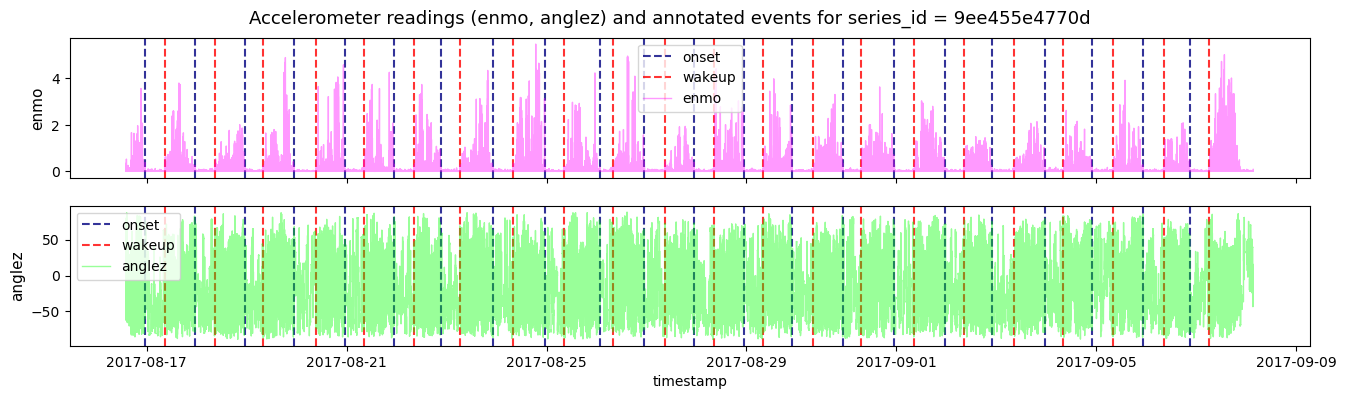

In [6]:
def plot_series_and_events(series_id, train_merged):
    # Make local copy of datasets
    data = train_merged.copy()
    # Filter the DataFrame based on the series_id
    sample_series = data[data['series_id'] == series_id].copy()
    # Convert timestamp to Pandas datetime object
    sample_series['Date'] = sample_series['timestamp'].str.split('T', expand=True)[0]
    sample_series['Time'] = sample_series['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
    sample_series['timestamp'] = pd.to_datetime(sample_series['Date'] + ' ' + sample_series['Time'])
    # Filter event data based on the series_id
    sample_events = data[data['series_id'] == series_id].copy()
    sample_events['Date'] = sample_events['timestamp'].str.split('T', expand=True)[0]
    sample_events['Time'] = sample_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
    sample_events['timestamp'] = pd.to_datetime(sample_events['Date'] + ' ' + sample_events['Time'])
    # Separate events
    sample_onset = sample_events[sample_events['event'] == 'onset'] #.dropna()
    sample_wakeup = sample_events[sample_events['event'] == 'wakeup'] #.dropna()
    ####################################
    # Plot anglez and enmo along with onset and wakeup events
    fig, ax = plt.subplots(2, 1, figsize=(16, 4), sharex=True)
    fig.suptitle('Accelerometer readings (enmo, anglez) and annotated events for series_id = ' + series_id,
                 fontsize=13, y=0.95)
    ####################################    
    for onset in sample_onset['timestamp']:
        ax[0].axvline(x=onset, color='Navy', linestyle='--', label='onset', alpha=0.8)
    for wakeup in sample_wakeup['timestamp']:
        ax[0].axvline(x=wakeup, color='Red', linestyle='--', label='wakeup', alpha=0.8)    
    ax[0].plot(sample_series['timestamp'], sample_series['enmo'], label='enmo',
               linewidth=1, color='magenta', alpha=0.4)    
    ax[0].set_ylabel('enmo', fontsize=11)    
    handles, labels = ax[0].get_legend_handles_labels()
    new_labels, new_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
    ax[0].legend(new_handles, new_labels, loc='best', fontsize=10)            
    ####################################    
    for onset in sample_onset['timestamp']:
        ax[1].axvline(x=onset, color='Navy', ls='--', label='onset', alpha=0.8)        
    for wakeup in sample_wakeup['timestamp']:
        ax[1].axvline(x=wakeup, color='Red', ls='--', label='wakeup', alpha=0.8)        
    ax[1].plot(sample_series['timestamp'], sample_series['anglez'], label='anglez',
               linewidth=1, color='lime', alpha=0.4)    
    ax[1].set_ylabel('anglez',fontsize=11)    
    handles, labels = ax[1].get_legend_handles_labels()
    new_labels, new_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
    ax[1].legend(new_handles, new_labels, loc='best', fontsize=10)        
    ####################################    
    plt.xlabel('timestamp')
    plt.show()

plot_series_and_events(selected_series[1], train_merged)

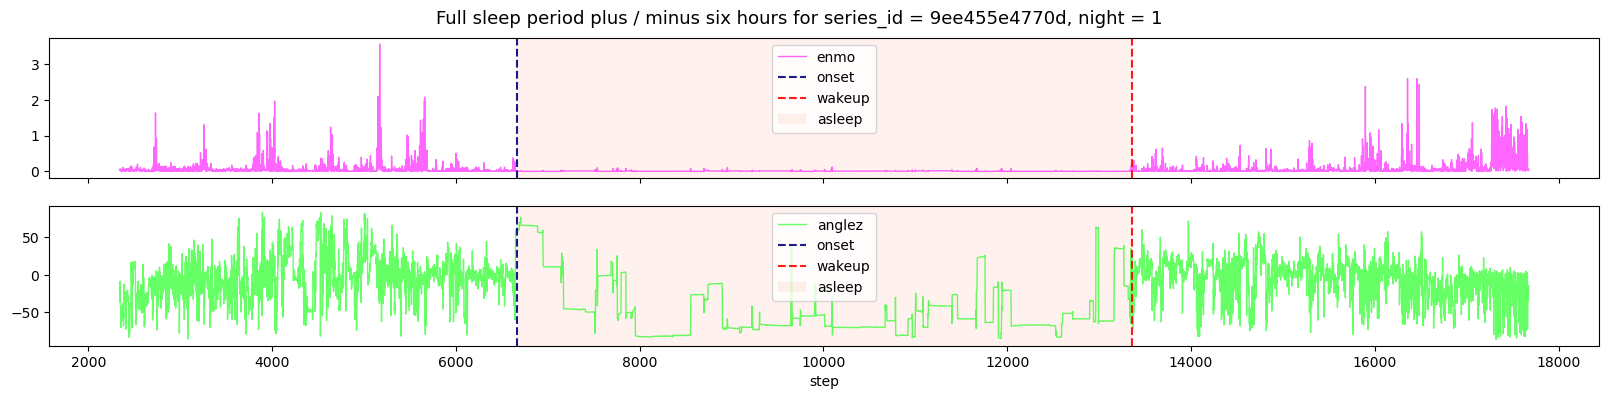

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


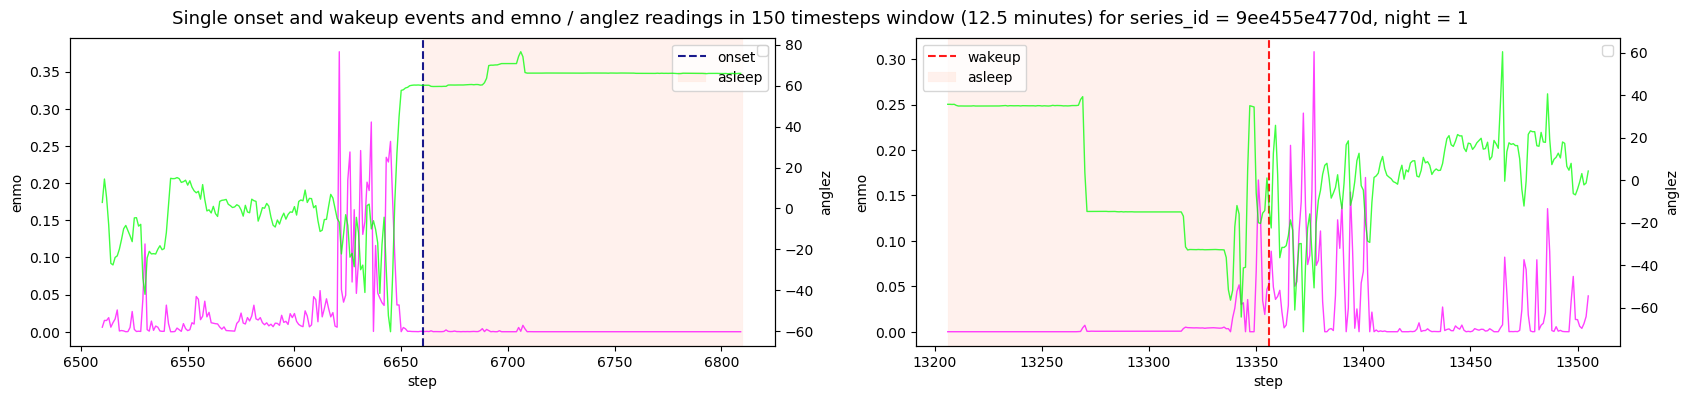

In [7]:
window = 4320 # full sleep period plus six hours before and after
# Function to plot one pair onset - wakeup of events
timestep_intv = 300 # 1 hr

def plot_event_pair(series_id, night, train_merged, w=window):
    # Extract onset and wakeup events on the night
    onset_id = train_merged[(train_merged['series_id']==series_id) &
                            (train_merged['night']==night) &
                            (train_merged['event']=='onset')].index[0]
    wakeup_id = train_merged[(train_merged['series_id']==series_id) &
                             (train_merged['night']==night) &
                             (train_merged['event']=='wakeup')].index[0]
    sample_pair = train_merged.iloc[onset_id - w : wakeup_id + w]
    
    # Plot charts of enmo and anglez, with onset and wakeup events for one night
    fig, ax = plt.subplots(2,1, figsize=(20,4), sharex=True)
    fig.suptitle('Full sleep period plus / minus six hours for series_id = ' + str(series_id) + ', night = ' + str(night),
                 fontsize=13, y=0.95)
    #############
    ax[0].plot(sample_pair['step'], sample_pair['enmo'], label='enmo',
               color='magenta', lw=1, alpha=0.6)
    ax[0].axvline(train_merged.iloc[onset_id]['step'], label='onset', ls='--', color='Navy', alpha=0.9)
    ax[0].axvline(train_merged.iloc[wakeup_id]['step'], label='wakeup', ls='--', color='Red', alpha=0.9)
    ax[0].axvspan(train_merged.iloc[onset_id]['step'], train_merged.iloc[wakeup_id]['step'], ymin=0, ymax=1,
                  color='coral', linewidth=0.1, alpha=0.1, label='asleep')
    ax[0].legend(loc='best', fontsize=10)
    ##########################
    ax[1].plot(sample_pair['step'], sample_pair['anglez'], label='anglez',
                   color='lime', lw=1, alpha=0.6)
    ax[1].axvline(train_merged.iloc[onset_id]['step'], label='onset', ls='--', color='Navy', alpha=0.9)
    ax[1].axvline(train_merged.iloc[wakeup_id]['step'], label='wakeup', ls='--', color='Red', alpha=0.9)
    ax[1].axvspan(train_merged.iloc[onset_id]['step'], train_merged.iloc[wakeup_id]['step'], ymin=0, ymax=1,
                  color='coral', linewidth=0.1, alpha=0.1, label='asleep')
    ax[1].legend(loc='best', fontsize=10)
    ##########################
    plt.xlabel('step')
    plt.show()
    
    ##########################
    # Plot charts of single events (150 timestep windows)
    fig, ax = plt.subplots(1,2, figsize=(20,4), sharex=False)
    fig.suptitle('Single onset and wakeup events and emno / anglez readings in 150 timesteps window (12.5 minutes) for series_id = ' + str(series_id) + ', night = ' + str(night), 
                 fontsize=13, y=0.95)
    ##########################
    single_onset = train_merged.iloc[onset_id - (timestep_intv//2) : onset_id + (timestep_intv//2)]
    ax[0].plot(single_onset['step'], single_onset['enmo'], color='magenta', lw=1, alpha=0.75) 
    ax[0].axvline(train_merged.iloc[onset_id]['step'], ls='--', color='Navy', alpha=0.9, label='onset')
    ax[0].axvspan(train_merged.iloc[onset_id]['step'], train_merged.iloc[onset_id + (timestep_intv//2)]['step'], ymin=0, ymax=1,
                  color='coral', linewidth=0.1, alpha=0.1, label='asleep')
    ax[0].legend(loc='upper right', fontsize=10)
    ax[0].set_xlabel('step')
    ax[0].set_ylabel('enmo')
    ax0b = ax[0].twinx()
    ax0b.plot(single_onset['step'], single_onset['anglez'], color='lime', lw=1, alpha=0.75) 
    ax0b.set_ylabel('anglez')
    ax0b.legend(loc='best', fontsize=10)
    ##########################
    single_wakeup = train_merged.iloc[wakeup_id -(timestep_intv//2) : wakeup_id + (timestep_intv//2)]
    ax[1].plot(single_wakeup['step'], single_wakeup['enmo'], color='magenta', lw=1, alpha=0.75)
    ax[1].axvline(train_merged.iloc[wakeup_id]['step'], ls='--', color='Red', alpha=0.9, label='wakeup')
    ax[1].axvspan(train_merged.iloc[wakeup_id - (timestep_intv//2)]['step'], train_merged.iloc[wakeup_id]['step'], ymin=0, ymax=1,
                  color='coral', linewidth=0.1, alpha=0.1, label='asleep')
    ax[1].legend(loc='upper left', fontsize=10)
    ax[1].set_xlabel('step')
    ax[1].set_ylabel('enmo')
    ax1b = ax[1].twinx()
    ax1b.plot(single_wakeup['step'], single_wakeup['anglez'], color='lime', lw=1, alpha=0.75) 
    ax1b.set_ylabel('anglez')
    ax1b.legend(loc='best', fontsize=10)
    ##########################
    plt.show()
    

plot_event_pair(selected_series[1], 1, train_merged)

In [8]:
selected_series[1]

'9ee455e4770d'

In [9]:
list(train_merged[train_merged['event']=='onset'].index)[0]

4992

In [10]:
onset_records = list(train_merged[train_merged['event']=='onset'].index)
onset_samples = {}

for id in onset_records:
    onset_samples[id] = train_merged.iloc[id - (timestep_intv//2) : id + (timestep_intv//2)].copy()
    onset_samples[id]['asleep'] = 0
    onset_samples[id]['asleep'] = onset_samples[id]['event'].replace({"onset":1})
    onset_samples[id]['asleep'] = onset_samples[id]['asleep'].ffill(axis ='rows')
    onset_samples[id]['asleep'].fillna(value=0, inplace=True)
    
nbr_onset_samples = len(onset_samples.keys())
# print(onset_records)
print("Nbr. onset samples for training: " + str(nbr_onset_samples))

Nbr. onset samples for training: 4790


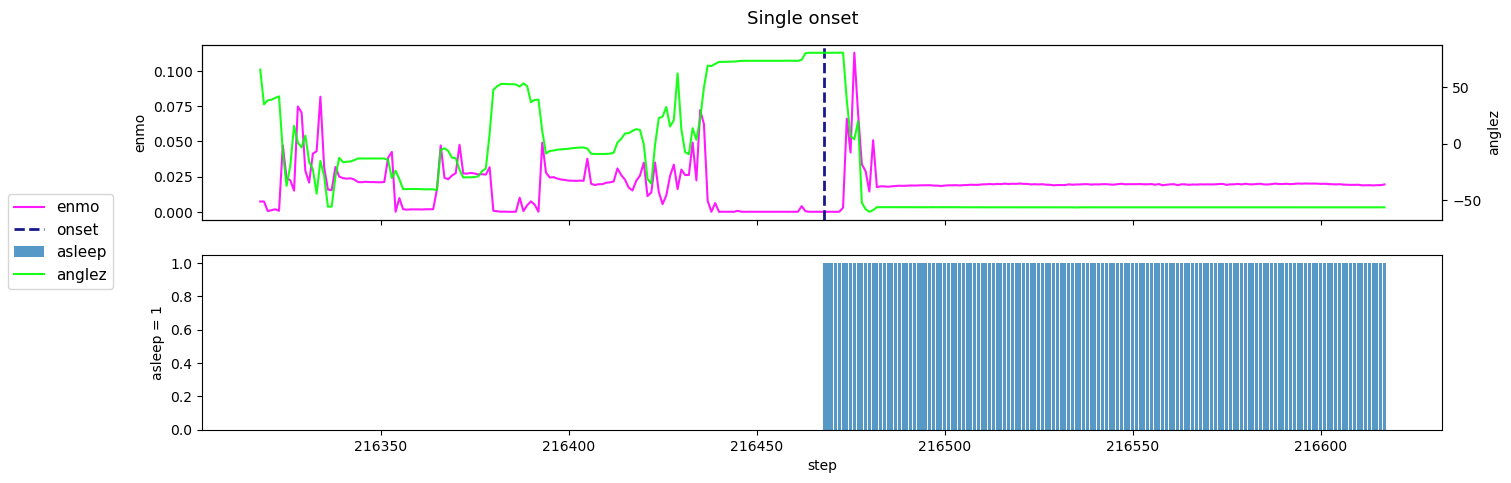

In [11]:
# Pick one onset_id randomly
onset_id = random.choice(onset_records)
# Plot enmo, anglez, event and asleep
fig, ax = plt.subplots(2,1, figsize=(16, 5), sharex=True)
fig.suptitle('Single onset', fontsize=13, y=0.95)
ax[0].plot(onset_samples[onset_id].step, onset_samples[onset_id].enmo, label='enmo', color='magenta', alpha=0.9)
ax[0].set_ylabel('enmo')
#####################
ax0b = ax[0].twinx()
ax0b.plot(onset_samples[onset_id].step, onset_samples[onset_id].anglez, label='anglez', color='lime', alpha=0.9)
ax0b.set_ylabel('anglez')
#####################
ax[0].axvline(train_merged.iloc[onset_id]['step'], label='onset', ls='--', lw=2, color='Navy', alpha=0.9) 
#####################
ax[1].bar(onset_samples[onset_id].step, onset_samples[onset_id].asleep, label='asleep', alpha=0.75)
ax[1].set_ylabel('asleep = 1')
ax[1].set_xlabel('step')
#####################
fig.legend(loc='center left', fontsize=11)
plt.show()

In [12]:
wakeup_records = list(train_merged[train_merged['event']=='wakeup'].index)
wakeup_samples = {}

for id in wakeup_records:
    wakeup_samples[id] = train_merged.iloc[id - (timestep_intv//2) : id + (timestep_intv//2)].copy()
    wakeup_samples[id]['asleep'] = 0
    wakeup_samples[id]['asleep'] = wakeup_samples[id]['event'].replace({"wakeup":1})
    wakeup_samples[id]['asleep'] = wakeup_samples[id]['asleep'].bfill(axis ='rows')
    wakeup_samples[id]['asleep'].fillna(value=0, inplace=True)

nbr_wakeup_samples = len(wakeup_samples.keys())
# print(wakeup_samples)
print("Nbr. wakeup samples for training: " + str(nbr_wakeup_samples))

Nbr. wakeup samples for training: 4790


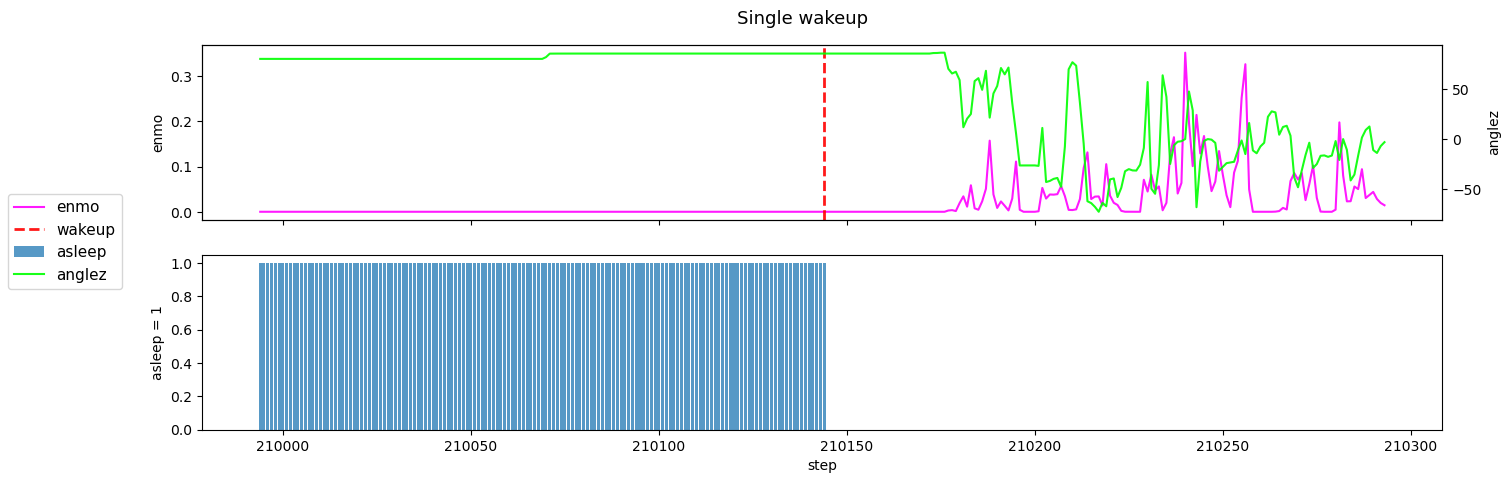

In [13]:
# Pick one wakeup_id randomly
wakeup_id = random.choice(wakeup_records)
# Plot enmo, anglez, event and asleep
fig, ax = plt.subplots(2,1, figsize=(16, 5), sharex=True)
fig.suptitle('Single wakeup', fontsize=13, y=0.95)
ax[0].plot(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].enmo, label='enmo', color='magenta', alpha=0.9)
ax[0].set_ylabel('enmo')
#####################
ax0b = ax[0].twinx()
ax0b.plot(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].anglez, label='anglez', color='lime', alpha=0.9)
ax0b.set_ylabel('anglez')
#####################
ax[0].axvline(train_merged.iloc[wakeup_id]['step'], label='wakeup', ls='--',  lw=2, color='Red', alpha=0.9) 
#####################
ax[1].bar(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].asleep, label='asleep', alpha=0.75)
ax[1].set_ylabel('asleep = 1')
ax[1].set_xlabel('step')
#####################
fig.legend(loc='center left', fontsize=11)
plt.show()

In [14]:
# # onset_samples.keys()
# onset_samples

In [15]:
# first_5_keys = list(onset_samples.keys())[:5]

# # Concatenate the corresponding DataFrames
# onset_samples_df_train = pd.concat([onset_samples[key] for key in first_5_keys], axis=0)

# # Display the result
# print(onset_samples_df_train)

In [16]:
# onset_samples_df_train = pd.concat(onset_samples, axis=0)
# onset_samples_df_train

In [17]:
# build dataframes of onsets and wakeups from samples dictionaries
onset_samples_df = pd.concat(onset_samples, axis=0)
wakeup_samples_df = pd.concat(wakeup_samples, axis=0)


In [18]:
onset_samples_df

series_id    step                 timestamp  anglez  \
4992      4842       038441c925bb    4842  2018-08-14T22:13:30-0400  -57.15   
          4843       038441c925bb    4843  2018-08-14T22:13:35-0400  -57.19   
          4844       038441c925bb    4844  2018-08-14T22:13:40-0400  -57.33   
          4845       038441c925bb    4845  2018-08-14T22:13:45-0400  -57.69   
          4846       038441c925bb    4846  2018-08-14T22:13:50-0400   20.03   
...                           ...     ...                       ...     ...   
124804320 124804465  fe90110788d2  574765  2017-09-06T23:47:05-0400   56.52   
          124804466  fe90110788d2  574766  2017-09-06T23:47:10-0400   56.52   
          124804467  fe90110788d2  574767  2017-09-06T23:47:15-0400   56.52   
          124804468  fe90110788d2  574768  2017-09-06T23:47:20-0400   56.52   
          124804469  fe90110788d2  574769  2017-09-06T23:47:25-0400   56.52   

                         enmo  night event  asleep  
4992      4842       9.20e-03    NaN  None     0.0  
          4843       8.70e-03    NaN  None     0.0  
          4844       8.50e-03    NaN  None     0.0  
          4845       1.32e-02    NaN  None     0.0  
          4846       4.52e-02    NaN  None     0.0  
...                       ...    ...   ...     ...  
124804320 124804465  0.00e+00    NaN  None     1.0  
          124804466  0.00e+00    NaN  None     1.0  
          124804467  0.00e+00    NaN  None     1.0  
          124804468  0.00e+00    NaN  None     1.0  
          124804469  0.00e+00    NaN  None     1.0  

[1437000 rows x 8 columns]

In [19]:
df1 = onset_samples_df[['series_id', 'asleep', 'anglez', 'enmo']].copy()
df2 = wakeup_samples_df[['series_id', 'asleep', 'anglez', 'enmo']].copy()

df1['enmo_diff'] = onset_samples_df['enmo'].diff(1)
df1['anglez_diff'] = onset_samples_df['anglez'].diff(1)

df1['enmo_ma'] = onset_samples_df['enmo'].rolling(12).mean() # 12 steps = 1 minute
df1['anglez_ma'] = onset_samples_df['anglez'].rolling(12).mean()

df2['enmo_diff'] = wakeup_samples_df['enmo'].diff(1)
df2['anglez_diff'] = wakeup_samples_df['anglez'].diff(1)

df2['enmo_ma'] = wakeup_samples_df['enmo'].rolling(12).mean()
df2['anglez_ma'] = wakeup_samples_df['anglez'].rolling(12).mean()

# Concatenate the DataFrames
df = pd.concat([df1, df2], axis=0)

# Fill missing values
df = df.fillna(method='ffill').fillna(method='bfill')

df= df.sort_index()

# # Reset the index before sorting and shuffling
# df = df.reset_index()

# # Sort and shuffle based on 'series_id'
# shuffled_df = df.sort_values(by='series_id').sample(frac=1, random_state=42)

# # Drop the temporary index column created by reset_index
# shuffled_df = shuffled_df.drop(columns='index')

# Each sample iss a 150 steps sequence with a single onset or wakeup event
NBR_TRAINING_SAMPLES = nbr_onset_samples + nbr_wakeup_samples
print("Nbr. samples for training: " + str(NBR_TRAINING_SAMPLES))

Nbr. samples for training: 9580


In [20]:
df

series_id  asleep  anglez      enmo  enmo_diff  \
4992      4842       038441c925bb     0.0  -57.15  9.20e-03  -5.00e-04   
          4843       038441c925bb     0.0  -57.19  8.70e-03  -5.00e-04   
          4844       038441c925bb     0.0  -57.33  8.50e-03  -2.00e-04   
          4845       038441c925bb     0.0  -57.69  1.32e-02   4.70e-03   
          4846       038441c925bb     0.0   20.03  4.52e-02   3.20e-02   
...                           ...     ...     ...       ...        ...   
124811304 124811449  fe90110788d2     0.0  -14.48  6.00e-04   6.00e-04   
          124811450  fe90110788d2     0.0  -14.04  0.00e+00  -6.00e-04   
          124811451  fe90110788d2     0.0  -14.05  0.00e+00   0.00e+00   
          124811452  fe90110788d2     0.0  -14.36  9.00e-04   9.00e-04   
          124811453  fe90110788d2     0.0  -15.25  0.00e+00  -9.00e-04   

                     anglez_diff   enmo_ma  anglez_ma  
4992      4842             -0.04  9.49e-03       6.06  
          4843             -0.04  9.49e-03       6.06  
          4844             -0.15  9.49e-03       6.06  
          4845             -0.36  9.49e-03       6.06  
          4846             77.72  9.49e-03       6.06  
...                          ...       ...        ...  
124811304 124811449         0.04  6.36e-03     -40.27  
          124811450         0.44  6.36e-03     -35.82  
          124811451        -0.01  6.36e-03     -31.38  
          124811452        -0.31  6.43e-03     -26.95  
          124811453        -0.89  6.23e-03     -22.64  

[2874000 rows x 8 columns]

In [21]:
df2.index

MultiIndex([(    10932,     10782),
            (    10932,     10783),
            (    10932,     10784),
            (    10932,     10785),
            (    10932,     10786),
            (    10932,     10787),
            (    10932,     10788),
            (    10932,     10789),
            (    10932,     10790),
            (    10932,     10791),
            ...
            (124811304, 124811444),
            (124811304, 124811445),
            (124811304, 124811446),
            (124811304, 124811447),
            (124811304, 124811448),
            (124811304, 124811449),
            (124811304, 124811450),
            (124811304, 124811451),
            (124811304, 124811452),
            (124811304, 124811453)],
           length=1437000)

In [22]:
len(list(df.series_id.unique()))

269

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2874000 entries, (4992, 4842) to (124811304, 124811453)
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   series_id    object 
 1   asleep       float64
 2   anglez       float32
 3   enmo         float32
 4   enmo_diff    float32
 5   anglez_diff  float32
 6   enmo_ma      float64
 7   anglez_ma    float64
dtypes: float32(4), float64(3), object(1)
memory usage: 234.8+ MB


In [24]:
onset_samples_df

series_id    step                 timestamp  anglez  \
4992      4842       038441c925bb    4842  2018-08-14T22:13:30-0400  -57.15   
          4843       038441c925bb    4843  2018-08-14T22:13:35-0400  -57.19   
          4844       038441c925bb    4844  2018-08-14T22:13:40-0400  -57.33   
          4845       038441c925bb    4845  2018-08-14T22:13:45-0400  -57.69   
          4846       038441c925bb    4846  2018-08-14T22:13:50-0400   20.03   
...                           ...     ...                       ...     ...   
124804320 124804465  fe90110788d2  574765  2017-09-06T23:47:05-0400   56.52   
          124804466  fe90110788d2  574766  2017-09-06T23:47:10-0400   56.52   
          124804467  fe90110788d2  574767  2017-09-06T23:47:15-0400   56.52   
          124804468  fe90110788d2  574768  2017-09-06T23:47:20-0400   56.52   
          124804469  fe90110788d2  574769  2017-09-06T23:47:25-0400   56.52   

                         enmo  night event  asleep  
4992      4842       9.20e-03    NaN  None     0.0  
          4843       8.70e-03    NaN  None     0.0  
          4844       8.50e-03    NaN  None     0.0  
          4845       1.32e-02    NaN  None     0.0  
          4846       4.52e-02    NaN  None     0.0  
...                       ...    ...   ...     ...  
124804320 124804465  0.00e+00    NaN  None     1.0  
          124804466  0.00e+00    NaN  None     1.0  
          124804467  0.00e+00    NaN  None     1.0  
          124804468  0.00e+00    NaN  None     1.0  
          124804469  0.00e+00    NaN  None     1.0  

[1437000 rows x 8 columns]

In [25]:
wakeup_samples_df

series_id    step                 timestamp  anglez  \
10932     10782      038441c925bb   10782  2018-08-15T06:28:30-0400  -67.50   
          10783      038441c925bb   10783  2018-08-15T06:28:35-0400  -67.53   
          10784      038441c925bb   10784  2018-08-15T06:28:40-0400  -67.51   
          10785      038441c925bb   10785  2018-08-15T06:28:45-0400  -67.52   
          10786      038441c925bb   10786  2018-08-15T06:28:50-0400  -67.51   
...                           ...     ...                       ...     ...   
124811304 124811449  fe90110788d2  581749  2017-09-07T09:29:05-0400  -14.48   
          124811450  fe90110788d2  581750  2017-09-07T09:29:10-0400  -14.04   
          124811451  fe90110788d2  581751  2017-09-07T09:29:15-0400  -14.05   
          124811452  fe90110788d2  581752  2017-09-07T09:29:20-0400  -14.36   
          124811453  fe90110788d2  581753  2017-09-07T09:29:25-0400  -15.25   

                         enmo  night event  asleep  
10932     10782      2.08e-02    NaN  None     1.0  
          10783      2.09e-02    NaN  None     1.0  
          10784      2.06e-02    NaN  None     1.0  
          10785      2.09e-02    NaN  None     1.0  
          10786      2.05e-02    NaN  None     1.0  
...                       ...    ...   ...     ...  
124811304 124811449  6.00e-04    NaN  None     0.0  
          124811450  0.00e+00    NaN  None     0.0  
          124811451  0.00e+00    NaN  None     0.0  
          124811452  9.00e-04    NaN  None     0.0  
          124811453  0.00e+00    NaN  None     0.0  

[1437000 rows x 8 columns]

In [26]:
df.index[0][:10]

(4992, 4842)

In [27]:
df_sorted = df.sort_index()

In [28]:
unique_values = df_sorted.index.get_level_values(0).unique()
unique_values

Index([     4992,     10932,     20244,     27492,     39996,     44400,
           57240,     62856,     91296,     97860,
       ...
       124734816, 124740984, 124752552, 124758804, 124768656, 124776852,
       124786260, 124790304, 124804320, 124811304],
      dtype='int64', length=9580)

In [29]:
TIMESTEPS = timestep_intv
features = ['anglez', 'enmo', 'anglez_diff', 'enmo_diff',  'anglez_ma', 'enmo_ma']
NBR_FEATURES = len(features)

X = df[features].to_numpy().reshape(NBR_TRAINING_SAMPLES, TIMESTEPS, NBR_FEATURES)
y = df['asleep'].to_numpy().reshape(NBR_TRAINING_SAMPLES, TIMESTEPS)

print('X shape:' + str(X.shape))
print('y shape:' + str(y.shape))

X shape:(9580, 300, 6)
y shape:(9580, 300)


In [30]:
y

array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [31]:
X[1,1,1]

0.020899999886751175

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)

In [33]:
X_train[1,1,1]

0.020899999886751175

In [34]:
X_val.shape

(958, 300, 6)

In [35]:
X_test.shape

(958, 300, 6)

In [36]:
# np.unique(X_val[:, 0, 0])

In [37]:
NBR_TRAINING_SAMPLES = X_train.shape[0]

In [38]:
#####################################################
# RNN training parameters
BATCH_SIZE = 32
EPOCHS = 40
#####################################################
# Input layer
input_layer = Input(shape=(TIMESTEPS, NBR_FEATURES)) 

# Convolutional layer
conv_layer = Conv1D(filters=32, 
                    kernel_size=8,
                    strides=1,
                    activation='relu',
                    padding='same')(input_layer)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(TIMESTEPS, return_sequences=True))(conv_layer)
# Output layer
output_layer = Dense(1, activation='sigmoid')(lstm_layer)
# Build the RNN model
RNN = Model(inputs=input_layer, outputs=output_layer)

RNN.summary()





2023-12-05 09:39:30.058134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 32)           1568      
                                                                 
 bidirectional (Bidirectiona  (None, 300, 600)         799200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 300, 1)            601       
                                                                 
Total params: 801,369
Trainable params: 801,369
Non-trainable params: 0
_________________________________________________________________


In [39]:
print()
print('TRAINING DATASET DIMENSIONS')
print('-'*80)
print('  NUMBER OF TRAINING SERIES : ' + str(NBR_SAMPLES))
print('  NUMBER OF TRAINING SAMPLES : ' + str(NBR_TRAINING_SAMPLES))
print('  TIMESTEPS PER SAMPLE : ' + str(TIMESTEPS))
print('  NUMBER OF FEATURES : ' + str(NBR_FEATURES ))
print()
print('NEURAL NETWORK TRAINING PARAMETERS')
print('-'*80)
print('  BATCH SIZE : ' + str(BATCH_SIZE))
print('  NUMBER OF EPOCHS : ' + str(EPOCHS))
print()


TRAINING DATASET DIMENSIONS
--------------------------------------------------------------------------------
  NUMBER OF TRAINING SERIES : 269
  NUMBER OF TRAINING SAMPLES : 7664
  TIMESTEPS PER SAMPLE : 300
  NUMBER OF FEATURES : 6

NEURAL NETWORK TRAINING PARAMETERS
--------------------------------------------------------------------------------
  BATCH SIZE : 32
  NUMBER OF EPOCHS : 40



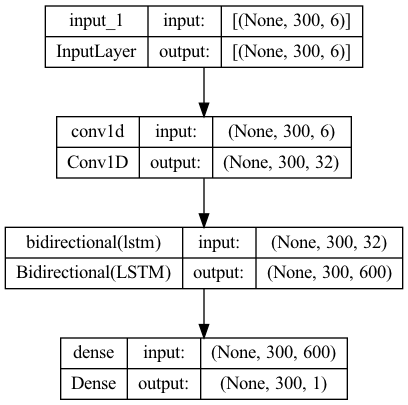

In [40]:
plot_model(RNN, "model_architecture.png", show_shapes=True)

In [41]:
%%time
# Compile model
RNN.compile(optimizer=Adamax(learning_rate=1e-3),
            loss=BinaryCrossentropy(),
           metrics=['accuracy'])

# Define EarlyStopping callback
callback = EarlyStopping(monitor='loss', patience=3)

# Fit the model with the data
RNN_history = RNN.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      callbacks=[callback],
                      validation_data=(X_val, y_val))

Epoch 1/40
240/240 [==============================] - 325s 1s/step - loss: 0.3784 - accuracy: 0.8396 - val_loss: 0.3682 - val_accuracy: 0.8507
Epoch 2/40
240/240 [==============================] - 322s 1s/step - loss: 0.2903 - accuracy: 0.8829 - val_loss: 0.3315 - val_accuracy: 0.8641
Epoch 3/40
240/240 [==============================] - 320s 1s/step - loss: 0.2429 - accuracy: 0.9046 - val_loss: 0.2742 - val_accuracy: 0.8892
Epoch 4/40
240/240 [==============================] - 326s 1s/step - loss: 0.2066 - accuracy: 0.9185 - val_loss: 0.2363 - val_accuracy: 0.9071
Epoch 5/40
240/240 [==============================] - 695s 3s/step - loss: 0.1859 - accuracy: 0.9272 - val_loss: 0.2188 - val_accuracy: 0.9139
Epoch 6/40
240/240 [==============================] - 287s 1s/step - loss: 0.1738 - accuracy: 0.9318 - val_loss: 0.2163 - val_accuracy: 0.9147
Epoch 7/40
240/240 [==============================] - 3196s 13s/step - loss: 0.1629 - accuracy: 0.9364 - val_loss: 0.2173 - val_accuracy: 0.91

In [42]:
%%time
# Convert the training history to a dataframe
RNN_history_df = pd.DataFrame(RNN_history.history)

RNN_history_df.describe()

CPU times: user 9.16 ms, sys: 20.1 ms, total: 29.3 ms
Wall time: 113 ms


,loss,accuracy,val_loss,val_accuracy
count,40.00,40.00,40.00,40.00
mean,0.11,0.96,0.17,0.94
std,0.07,0.03,0.06,0.02
min,0.04,0.84,0.12,0.85
25%,0.06,0.95,0.13,0.93
50%,0.08,0.97,0.15,0.94
75%,0.14,0.98,0.18,0.95
max,0.38,0.98,0.37,0.95


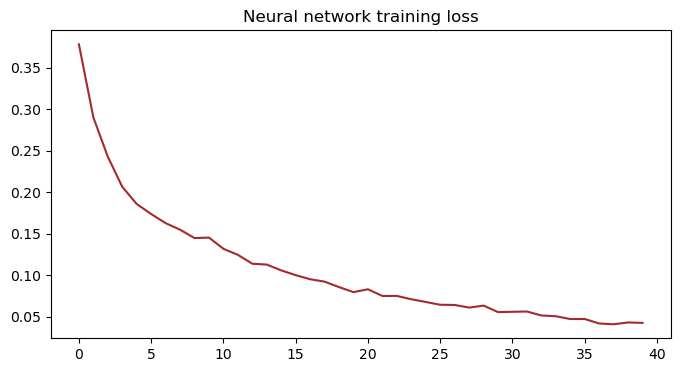

In [43]:
# Plot RNN training loss vs. epochs
# Plot the loss
ax_nn_loss = RNN_history_df['loss'].plot(figsize=(8, 4), title='Neural network training loss', color='brown')

# Save the plot to a file
plt.savefig('neural_network_training_loss_plot.png')

# Show the plot (optional)
plt.show()

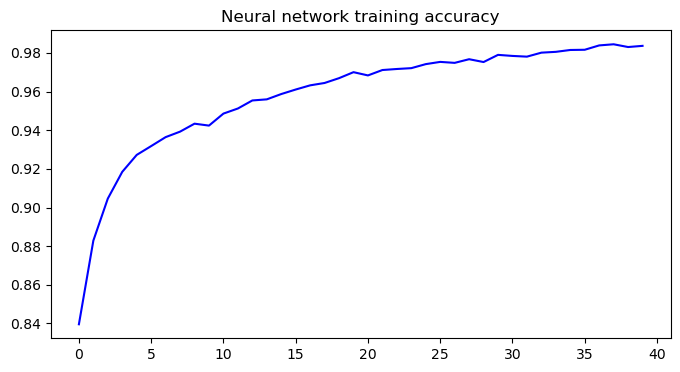

In [44]:
# Plot RNN training accuracy vs. epochs
ax_nn_acc = RNN_history_df['accuracy'].plot(figsize=(8,4), title='Neural network training accuracy', color='blue');

# Save the plot to a file
plt.savefig('neural_network_training_accuracy_plot.png')

# Show the plot (optional)
plt.show()

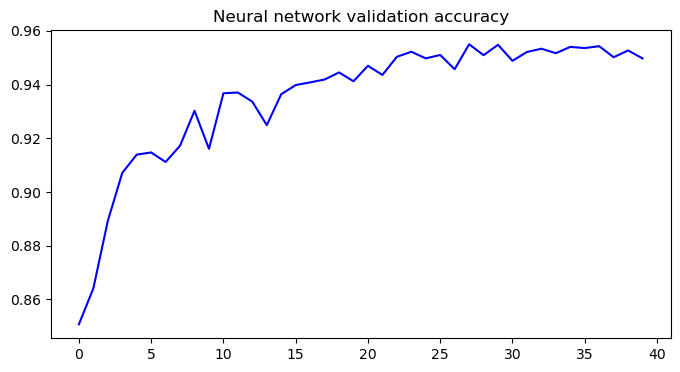

In [45]:
# Plot RNN training accuracy vs. epochs
ax_nn_acc = RNN_history_df['val_accuracy'].plot(figsize=(8,4), title='Neural network validation accuracy', color='blue');

# Save the plot to a file
plt.savefig('neural_network_val_accuracy_plot.png')

# Show the plot (optional)
plt.show()

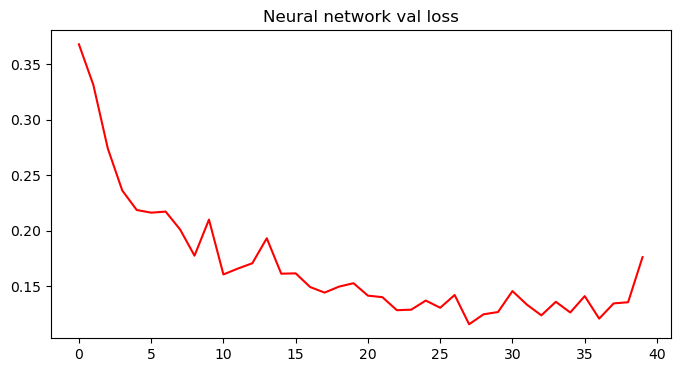

In [46]:
# Plot RNN training accuracy vs. epochs
ax_nn_acc = RNN_history_df['val_loss'].plot(figsize=(8,4), title='Neural network val loss', color='red');

# Save the plot to a file
plt.savefig('neural_network_val_loss_plot.png')

# Show the plot (optional)
plt.show()

## Training Set

In [47]:
predicted_train_values = RNN.predict(X_train)

240/240 [==============================] - 53s 218ms/step


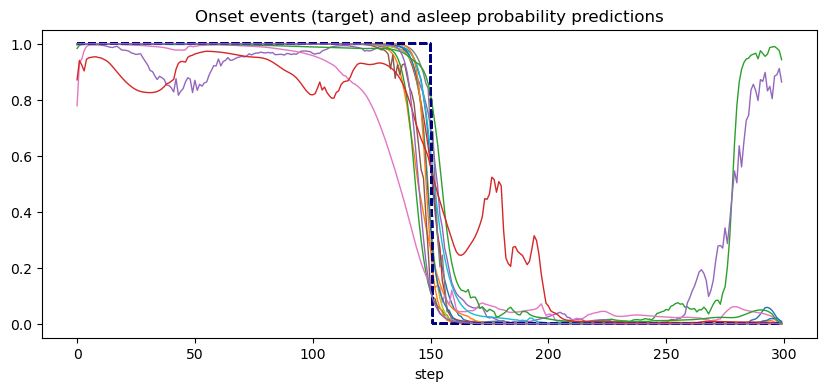

In [48]:
# Onset predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for i in range(1, 30, 2):
    ax.set_title('Onset events (target) and asleep probability predictions')
    ax.plot(y_test[i], linestyle='--', color='Navy', label='Target')
    ax.plot(predicted_train_values[i], lw=1, label='Predicted')
    ax.set_xlabel('step')

# Save the figure before displaying it
plt.savefig('onset_pred.jpg')

# Show the figure
plt.show()

In [50]:
predicted_asleep_state_training = np.where(predicted_train_values > 0.5, 1, 0 )
from sklearn.metrics import accuracy_score

# Flatten the arrays to 1D
y_train_flat = [item for sublist in y_train for item in sublist]
predicted_train_values_flat = [item for sublist in predicted_asleep_state_training for item in sublist]

# Calculate accuracy
accuracy = accuracy_score(y_train_flat, predicted_train_values_flat)
accuracy


0.9775052192066805

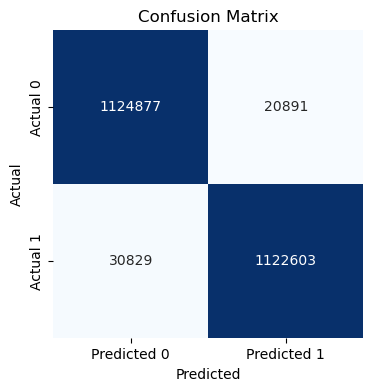

In [51]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix_training = confusion_matrix(y_train_flat, predicted_train_values_flat)
conf_matrix_training

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_training, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [52]:
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(y_train_flat, predicted_train_values_flat)

# Print or use the report as needed
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98   1145768
         1.0       0.98      0.97      0.98   1153432

    accuracy                           0.98   2299200
   macro avg       0.98      0.98      0.98   2299200
weighted avg       0.98      0.98      0.98   2299200



## Validation Set

In [53]:
predicted_val_values = RNN.predict(X_val)

30/30 [==============================] - 11s 368ms/step


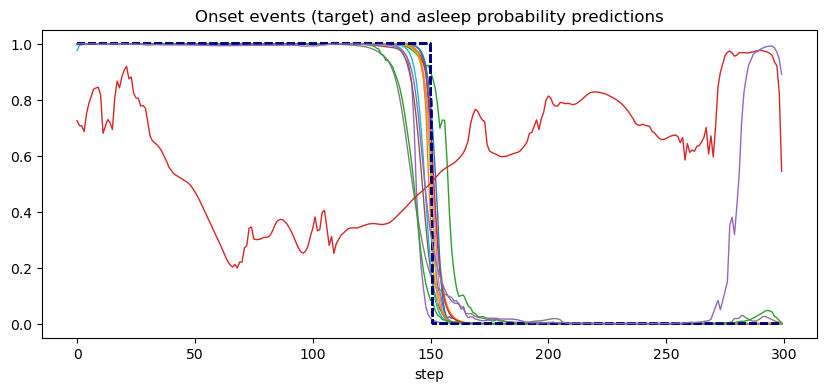

In [54]:
# Onset predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for i in range(1, 30, 2):
    ax.set_title('Onset events (target) and asleep probability predictions')
    ax.plot(y_val[i], linestyle='--', color='Navy', label='Target')
    ax.plot(predicted_val_values[i], lw=1, label='Predicted')
    ax.set_xlabel('step')

# Save the figure before displaying it
plt.savefig('onset_pred.jpg')

# Show the figure
plt.show()

In [55]:
predicted_asleep_state_val = np.where(predicted_val_values > 0.5, 1, 0 )
# Flatten the arrays to 1D
y_val_flat = [item for sublist in y_val for item in sublist]
predicted_val_values_flat = [item for sublist in predicted_asleep_state_val for item in sublist]

# Calculate accuracy
accuracy = accuracy_score(y_val_flat, predicted_val_values_flat)
accuracy


0.9497216423103688

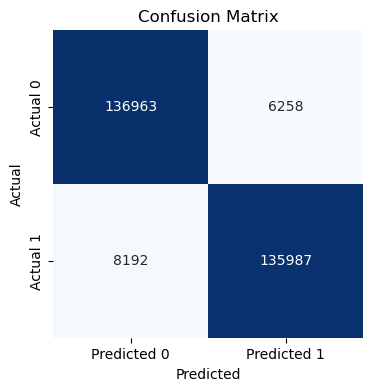

In [56]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix_val = confusion_matrix(y_val_flat, predicted_val_values_flat)
conf_matrix_val

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [57]:
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(y_val_flat, predicted_val_values_flat)

# Print or use the report as needed
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95    143221
         1.0       0.96      0.94      0.95    144179

    accuracy                           0.95    287400
   macro avg       0.95      0.95      0.95    287400
weighted avg       0.95      0.95      0.95    287400



## Test Set

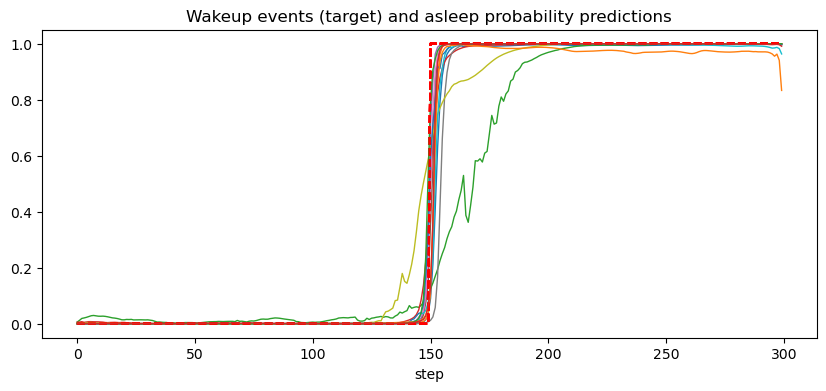

In [58]:
# Wakeup predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for i in range(2, 30, 2):
    ax.set_title('Wakeup events (target) and asleep probability predictions')
    ax.plot(y_test[i], linestyle='--', color='Red', label='Target')
    ax.plot(predicted_train_values[i], lw=1, label='Predicted')
    ax.set_xlabel('step')

plt.savefig('wakeup_pred.jpg')

# Show the figure
plt.show()

In [68]:
# Make predictions and compare to true values
# X_test = X_train
# y_test = y_train
predicted_test_values = RNN.predict(X_test)

30/30 [==============================] - 11s 371ms/step


In [76]:
len(predicted_test_values)

958

In [60]:
len(y_test)

958

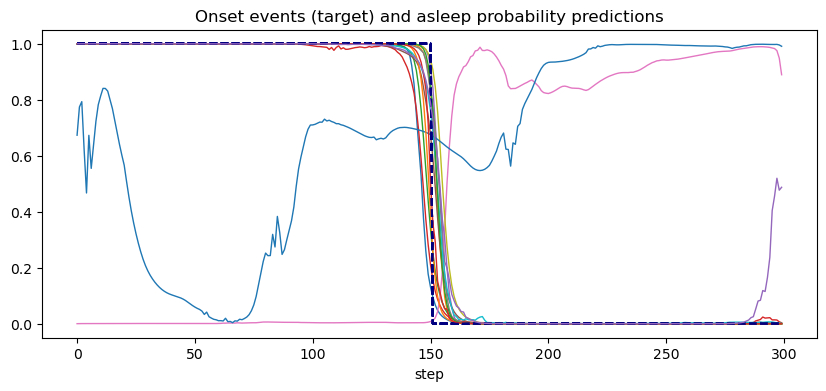

In [69]:
# Onset predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for i in range(1, 30, 2):
    ax.set_title('Onset events (target) and asleep probability predictions')
    ax.plot(y_test[i], linestyle='--', color='Navy', label='Target')
    ax.plot(predicted_test_values[i], lw=1, label='Predicted')
    ax.set_xlabel('step')

# Save the figure before displaying it
plt.savefig('onset_pred.jpg')

# Show the figure
plt.show()


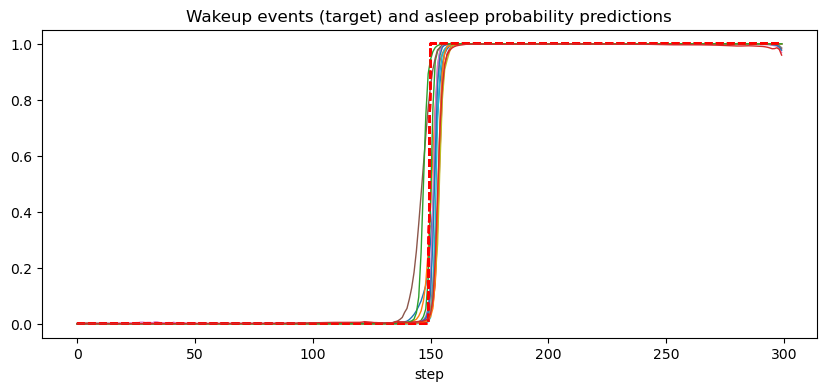

In [70]:
# Wakeup predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for i in range(2, 30, 2):
    ax.set_title('Wakeup events (target) and asleep probability predictions')
    ax.plot(y_test[i], linestyle='--', color='Red', label='Target')
    ax.plot(predicted_test_values[i], lw=1, label='Predicted')
    ax.set_xlabel('step')

plt.savefig('wakeup_pred.jpg')

# Show the figure
plt.show()


In [71]:
predicted_test_values.shape

(958, 300, 1)

In [64]:
# predicted_values[1]

In [77]:
from sklearn.metrics import accuracy_score
predicted_asleep_state_test = np.where(predicted_test_values > 0.5, 1, 0 )

# Flatten the arrays to 1D
y_test_flat = [item for sublist in y_test for item in sublist]
predicted_values_test_flat = [item for sublist in predicted_asleep_state for item in sublist]

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, predicted_values_test_flat)
accuracy

0.9470459290187891

In [78]:
# Convert predicted asleep probabilities to binary state
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(y_test_flat, predicted_values_test_flat)

# Print or use the report as needed
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    143221
         1.0       0.95      0.94      0.95    144179

    accuracy                           0.95    287400
   macro avg       0.95      0.95      0.95    287400
weighted avg       0.95      0.95      0.95    287400



In [79]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_flat, predicted_values_flat, average='binary')

# Print the results
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-score: {f1 * 100:.2f}%')

Precision: 95.34%
Recall: 94.04%
F1-score: 94.69%


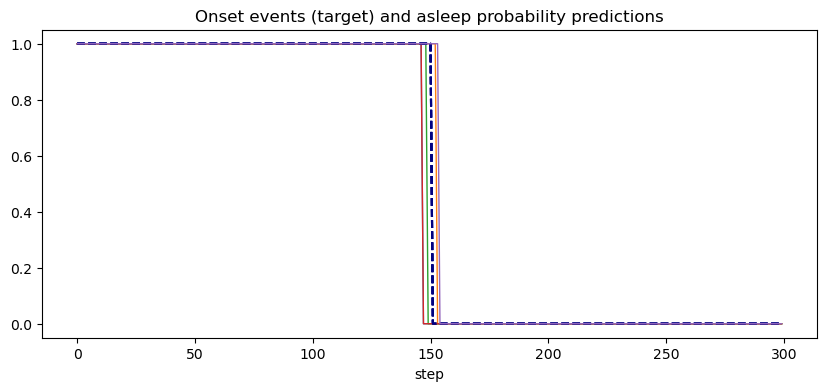

In [80]:
# Onset predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for i in range(1, 10, 2):
    ax.set_title('Onset events (target) and asleep probability predictions')
    ax.plot(y_test[i], linestyle='--', color='Navy', label='Target')
    ax.plot(predicted_asleep_state[i], lw=1, label='Predicted')
    ax.set_xlabel('step')

# Save the figure before displaying it
plt.savefig('onset_pred.jpg')

# Show the figure
plt.show()

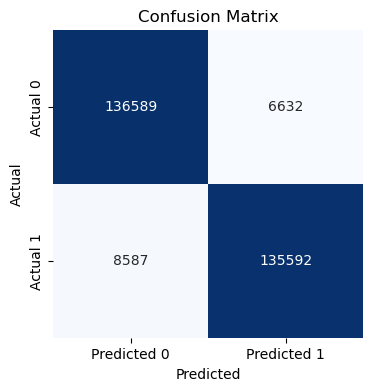

In [81]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_flat, predicted_values_flat)
conf_matrix

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [82]:
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(y_test_flat, predicted_values_flat)

# Print or use the report as needed
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    143221
         1.0       0.95      0.94      0.95    144179

    accuracy                           0.95    287400
   macro avg       0.95      0.95      0.95    287400
weighted avg       0.95      0.95      0.95    287400



In [83]:
from sklearn.metrics import accuracy_score

# Initialize an empty list to store individual accuracies
individual_accuracies = []

# Iterate through each line
for true_labels, predicted_labels in zip(y_test, predicted_asleep_state):
    # Calculate accuracy for the current line
    line_accuracy = accuracy_score(true_labels, predicted_labels)
    individual_accuracies.append(line_accuracy)

# Calculate the average accuracy
average_accuracy = sum(individual_accuracies) / len(individual_accuracies)

# # Print individual accuracies and average accuracy
# for i, acc in enumerate(individual_accuracies, 1):
#     print(f'Line {i} Accuracy: {acc * 100:.2f}%')

print(f'\nAverage Accuracy: {average_accuracy * 100:.2f}%')



Average Accuracy: 94.70%


In [84]:
from sklearn.metrics import precision_recall_fscore_support

# Initialize empty lists to store individual metrics
individual_precisions = []
individual_recalls = []
individual_f1_scores = []

# Iterate through each line
for true_labels, predicted_labels in zip(y_test, predicted_asleep_state):
    # Calculate precision, recall, and F1-score for the current line
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    
    # Append results to individual lists
    individual_precisions.append(precision)
    individual_recalls.append(recall)
    individual_f1_scores.append(f1)

# Calculate the average precision, recall, and F1-score
average_precision = sum(individual_precisions) / len(individual_precisions)
average_recall = sum(individual_recalls) / len(individual_recalls)
average_f1_score = sum(individual_f1_scores) / len(individual_f1_scores)

# # Print individual metrics and average metrics
# for i, (precision, recall, f1) in enumerate(zip(individual_precisions, individual_recalls, individual_f1_scores), 1):
#     print(f'Line {i}:')
#     print(f'  Precision: {precision * 100:.2f}%')
#     print(f'  Recall: {recall * 100:.2f}%')
#     print(f'  F1-score: {f1 * 100:.2f}%')
#     print()

print(f'Average Precision: {average_precision * 100:.2f}%')
print(f'Average Recall: {average_recall * 100:.2f}%')
print(f'Average F1-score: {average_f1_score * 100:.2f}%')


/Users/preranabajracharya/anaconda3/envs/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Precision: 95.01%
Average Recall: 94.05%
Average F1-score: 94.29%


In [85]:
NBR_VAL_SAMPLES = int(nbr_onset_samples *0.1 + nbr_wakeup_samples*0.1)
print(NBR_VAL_SAMPLES)
print(TIMESTEPS)
print(NBR_VAL_SAMPLES*TIMESTEPS)

958
300
287400


In [86]:
predicted_asleep_state.shape

(958, 300, 1)

In [87]:
# predictions_df['asleep'].shape

In [88]:
df.index

MultiIndex([(     4992,      4842),
            (     4992,      4843),
            (     4992,      4844),
            (     4992,      4845),
            (     4992,      4846),
            (     4992,      4847),
            (     4992,      4848),
            (     4992,      4849),
            (     4992,      4850),
            (     4992,      4851),
            ...
            (124811304, 124811444),
            (124811304, 124811445),
            (124811304, 124811446),
            (124811304, 124811447),
            (124811304, 124811448),
            (124811304, 124811449),
            (124811304, 124811450),
            (124811304, 124811451),
            (124811304, 124811452),
            (124811304, 124811453)],
           length=2874000)

In [89]:
predicted_asleep_state.T

array([[[0, 1, 0, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 0, 1],
        ...,
        [1, 0, 1, ..., 0, 1, 0],
        [1, 0, 1, ..., 0, 1, 0],
        [1, 0, 1, ..., 0, 1, 0]]])

In [90]:
last_10_percent_index = df.index[-int(0.1 * len(df)):]

# Create predictions_df with the last 10% of the index
predictions_df = pd.DataFrame(index=last_10_percent_index)
# predictions_df = pd.DataFrame(index=df.index)
predictions_df['asleep'] = predicted_asleep_state.reshape(NBR_VAL_SAMPLES*TIMESTEPS,1)
predictions_df['asleep_diff'] = predictions_df['asleep'].diff(1).fillna(method='bfill')
predictions_df['event'] = predictions_df['asleep_diff'].replace({1 : 'onset', -1 : 'wakeup'})

predictions_df

asleep  asleep_diff event
110543256 110543106       0          0.0   0.0
          110543107       0          0.0   0.0
          110543108       0          0.0   0.0
          110543109       0          0.0   0.0
          110543110       0          0.0   0.0
...                     ...          ...   ...
124811304 124811449       0          0.0   0.0
          124811450       0          0.0   0.0
          124811451       0          0.0   0.0
          124811452       0          0.0   0.0
          124811453       0          0.0   0.0

[287400 rows x 3 columns]

In [91]:
# Save the RNN model
RNN_name = 'RNN_' + str(NBR_SAMPLES) + '_SERIES_' + str(EPOCHS)+ '_EPOCHS'
RNN.save(RNN_name)

INFO:tensorflow:Assets written to: RNN_269_SERIES_40_EPOCHS/assets


INFO:tensorflow:Assets written to: RNN_269_SERIES_40_EPOCHS/assets


In [92]:
# Recovering memory
gc.collect()

148461

In [93]:
test_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.64,2.17e-02
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.64,2.15e-02
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.64,2.16e-02
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.64,2.13e-02
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.64,2.15e-02
...,...,...,...,...,...
445,0402a003dae9,145,2018-12-18T12:57:05-0500,-59.70,6.01e-02
446,0402a003dae9,146,2018-12-18T12:57:10-0500,-35.66,4.27e-02
447,0402a003dae9,147,2018-12-18T12:57:15-0500,-21.58,3.09e-02
448,0402a003dae9,148,2018-12-18T12:57:20-0500,-42.62,3.28e-02


In [94]:
test_series['step'] = test_series['step'].astype(np.int64) 
test_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  450 non-null    object 
 1   step       450 non-null    int64  
 2   timestamp  450 non-null    object 
 3   anglez     450 non-null    float32
 4   enmo       450 non-null    float32
dtypes: float32(2), int64(1), object(2)
memory usage: 14.2+ KB


In [95]:
test_series_ids = list(test_series['series_id'].unique())
NBR_TEST_SERIES = len(test_series_ids)
TIMESTEPS_PER_SAMPLE = 300 # every sleep period is more than 

print('Nbr. test series for submission: ' + str(NBR_TEST_SERIES))
print(test_series_ids)

Nbr. test series for submission: 3
['038441c925bb', '03d92c9f6f8a', '0402a003dae9']


In [96]:
def sample_test_series(df):
    # Create dictionary of test sequences
    series = {}
    # Iterate through the samples
    for id in test_series_ids:
        series[id] = df[df['series_id']==id].reset_index(drop=True)
        n_steps = len(series[id])
        n_samples = n_steps // TIMESTEPS_PER_SAMPLE
        l_samples = list(range(n_samples))
        samples = {}
        for s in l_samples:
            first_step = TIMESTEPS_PER_SAMPLE * s
            samples[s] = series[id].loc[first_step : first_step + TIMESTEPS_PER_SAMPLE - 1]
    series[id] = pd.concat([samples[s] for s in l_samples], axis='rows')

    # Concatenate samples into single test dataframe
    df = pd.concat([series[id] for id in test_series_ids], axis='rows').reset_index(drop=True)
    # Return updated dataframe
    return df
        
# Resample test_series dataset into set of sequences of 150 steps
test_series = sample_test_series(test_series)

In [97]:
def create_features(df):
    # Create dictionary of test sequences
    series = {}
    # Iterate through the samples to create derived features
    for id in test_series_ids:
        series[id] = df[df['series_id']==id]
        series[id]['anglez_diff'] = series[id]['anglez'].diff().fillna(method='bfill').fillna(method="ffill")   
        series[id]['enmo_diff'] = series[id]['enmo'].diff().fillna(method='bfill').fillna(method="ffill")   
        series[id]['anglez_ma'] = series[id]['anglez'].rolling(12).mean().fillna(method='bfill').fillna(method="ffill")    
        series[id]['enmo_ma'] = series[id]['enmo'].rolling(12).mean().fillna(method='bfill').fillna(method="ffill")   
    # Concatenate samples into single test dataframe
    df = pd.concat([series[id] for id in test_series_ids], axis=0)
    # Return updated dataframe
    return df

# Creature derived features
test_series = create_features(test_series)

/var/folders/dw/v4qq90490sxd2_vtfl7dgzyc0000gn/T/ipykernel_77790/1768196532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[id]['anglez_diff'] = series[id]['anglez'].diff().fillna(method='bfill').fillna(method="ffill")
/var/folders/dw/v4qq90490sxd2_vtfl7dgzyc0000gn/T/ipykernel_77790/1768196532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[id]['enmo_diff'] = series[id]['enmo'].diff().fillna(method='bfill').fillna(method="ffill")
/var/folders/dw/v4qq90490sxd2_vtfl7dgzyc0000gn/T/ipykern

In [117]:
def make_predictions(df):
    # Prepare input sequences for RNN
    features = ['anglez', 'enmo', 'anglez_diff', 'enmo_diff',  'anglez_ma', 'enmo_ma']
    NBR_FEATURES = len(features)
    TEST_SERIES_STEPS = len(df)

    # Isolate test set predictors
    X_test = df[features].to_numpy().reshape(NBR_TEST_SERIES, TIMESTEPS_PER_SAMPLE, NBR_FEATURES)
    # Make submission predictions (probabilities of asleep)
    test_predictions = RNN.predict(X_test)
    # Make binary asleep predictions (1=asleep)
    test_classes = np.where(test_predictions > 0.5, 1,0)
    # Reshape
    test_predictions = test_predictions.reshape(TEST_SERIES_STEPS, 1)
    test_classes = test_classes.reshape(TEST_SERIES_STEPS, 1) 
    
    # Create asleep and event predictions columns
    df['score'] = test_predictions
    df ['asleep'] =  test_classes
    df['asleep_diff'] = df['asleep'].diff().fillna(method='bfill').fillna(method="ffill")
    df['event'] = df[df['score']>0.5]['asleep_diff'].replace({1 : 'onset', -1 : 'wakeup'})
    
    return df

# Make predictions
test_series = make_predictions(test_series)

1/1 [==============================] - 0s 64ms/step


In [118]:
test_series.sample(5)

,series_id,step,timestamp,anglez,enmo,anglez_diff,enmo_diff,anglez_ma,enmo_ma,score,asleep,asleep_diff,event,night
408,0402a003dae9,108,2018-12-18T12:54:00-0500,-52.11,2.45e-02,-9.92,-0.03,-39.00,0.09,2.79e-03,0,0.0,NaN,13.0
23,038441c925bb,23,2018-08-14T15:31:55-0400,37.72,7.00e-03,-30.74,-0.02,28.07,0.02,9.99e-01,1,0.0,0.0,17.0
286,03d92c9f6f8a,136,2018-05-31T12:11:20-0400,-88.22,0.00e+00,0.00,0.00,-88.22,0.00,9.96e-01,1,0.0,0.0,132.0
226,03d92c9f6f8a,76,2018-05-31T12:06:20-0400,-88.22,0.00e+00,0.00,0.00,-88.22,0.00,9.79e-01,1,0.0,0.0,72.0
338,0402a003dae9,38,2018-12-18T12:48:10-0500,-11.23,2.55e-01,40.94,0.10,-19.05,0.07,3.06e-03,0,0.0,NaN,13.0


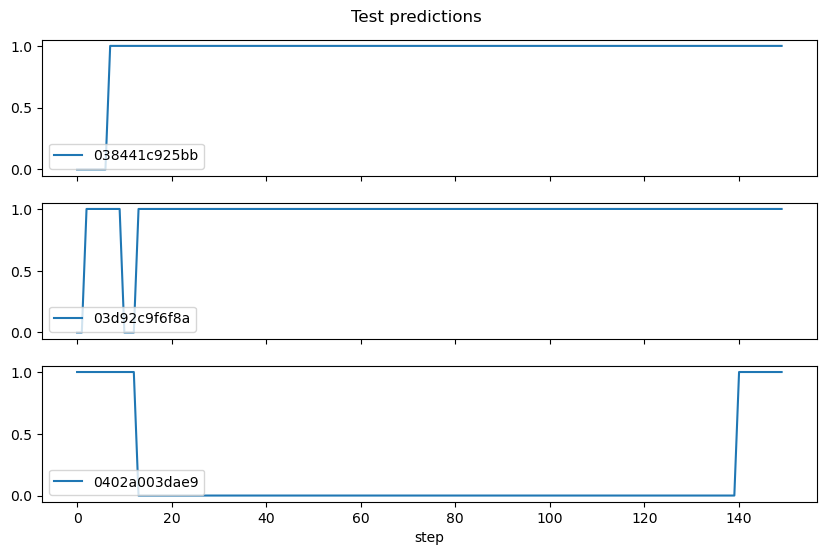

In [119]:
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex=True)
fig.suptitle('Test predictions', y=0.93)
i = 0
for id in test_series_ids:
    ax[i].plot(test_series[test_series['series_id']==id]['step'],
               test_series[test_series['series_id']==id]['asleep'],
               lw=1.5, label=id)
    ax[i].legend(loc='lower left')
    i = i + 1
plt.xlabel('step')
plt.show()

In [120]:
# Isolate events and add row_id
submission_df = test_series.loc[((test_series["event"]=='onset') |
                                 (test_series["event"]=='wakeup'))
                               ][["series_id","step","event","score"]].copy().reset_index(drop=True).reset_index(names="row_id")

submission_df

,row_id,series_id,step,event,score
0,0,038441c925bb,7,onset,0.59
1,1,03d92c9f6f8a,2,onset,0.57
2,2,03d92c9f6f8a,13,onset,0.51
3,3,0402a003dae9,140,onset,0.52


In [121]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_id     4 non-null      int64  
 1   series_id  4 non-null      object 
 2   step       4 non-null      int64  
 3   event      4 non-null      object 
 4   score      4 non-null      float32
dtypes: float32(1), int64(2), object(2)
memory usage: 272.0+ bytes


In [103]:
submission_df.to_csv('submission.csv', index=False)
print('finished')

finished


In [104]:
test_series[test_series['series_id'] == '038441c925bb']

,series_id,step,timestamp,anglez,enmo,anglez_diff,enmo_diff,anglez_ma,enmo_ma,score,asleep,asleep_diff,event
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.64,0.02,1.00e-04,-2.00e-04,2.69,0.02,0.10,0,0.0,NaN
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.64,0.02,1.00e-04,-2.00e-04,2.69,0.02,0.14,0,0.0,NaN
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.64,0.02,2.00e-04,1.00e-04,2.69,0.02,0.18,0,0.0,NaN
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.64,0.02,-2.00e-04,-3.00e-04,2.69,0.02,0.23,0,0.0,NaN
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.64,0.02,0.00e+00,2.00e-04,2.69,0.02,0.29,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,038441c925bb,145,2018-08-14T15:42:05-0400,-79.99,0.01,1.96e-01,-1.00e-04,-80.13,0.01,1.00,1,0.0,0.0
146,038441c925bb,146,2018-08-14T15:42:10-0400,-80.03,0.01,-3.84e-02,1.00e-04,-80.13,0.01,1.00,1,0.0,0.0
147,038441c925bb,147,2018-08-14T15:42:15-0400,-80.01,0.01,1.97e-02,1.00e-04,-80.12,0.01,1.00,1,0.0,0.0
148,038441c925bb,148,2018-08-14T15:42:20-0400,-80.07,0.01,-5.76e-02,-2.00e-04,-80.11,0.01,1.00,1,0.0,0.0


In [122]:
grouped_series = test_series.groupby('series_id')

# Apply the logic for each group
for series_id, group in grouped_series:
    night_start_indices = group.index[group['asleep'] == 1]
    
    night_number = 0
    for index in night_start_indices:
        night_number += 1
        test_series.loc[index:, 'night'] = night_number

# Print the resulting DataFrame
print(test_series)

        series_id  step                 timestamp  anglez      enmo  \
0    038441c925bb     0  2018-08-14T15:30:00-0400    2.64  2.17e-02   
1    038441c925bb     1  2018-08-14T15:30:05-0400    2.64  2.15e-02   
2    038441c925bb     2  2018-08-14T15:30:10-0400    2.64  2.16e-02   
3    038441c925bb     3  2018-08-14T15:30:15-0400    2.64  2.13e-02   
4    038441c925bb     4  2018-08-14T15:30:20-0400    2.64  2.15e-02   
..            ...   ...                       ...     ...       ...   
445  0402a003dae9   145  2018-12-18T12:57:05-0500  -59.70  6.01e-02   
446  0402a003dae9   146  2018-12-18T12:57:10-0500  -35.66  4.27e-02   
447  0402a003dae9   147  2018-12-18T12:57:15-0500  -21.58  3.09e-02   
448  0402a003dae9   148  2018-12-18T12:57:20-0500  -42.62  3.28e-02   
449  0402a003dae9   149  2018-12-18T12:57:25-0500    7.03  8.10e-03   

     anglez_diff  enmo_diff  anglez_ma  enmo_ma  score  asleep  asleep_diff  \
0       1.00e-04  -2.00e-04       2.69     0.02   0.10       0      

In [106]:
# min_timestamp = test_series[test_series['series_id'] == '0402a003dae9']['timestamp'].min()
# print(min_timestamp)
# #

In [107]:
# max_timestamp = test_series[test_series['series_id'] == '0402a003dae9']['timestamp'].max()
# # print(max_timestamp)


In [108]:
# len(list(test_series[test_series['series_id'] == '0402a003dae9']))

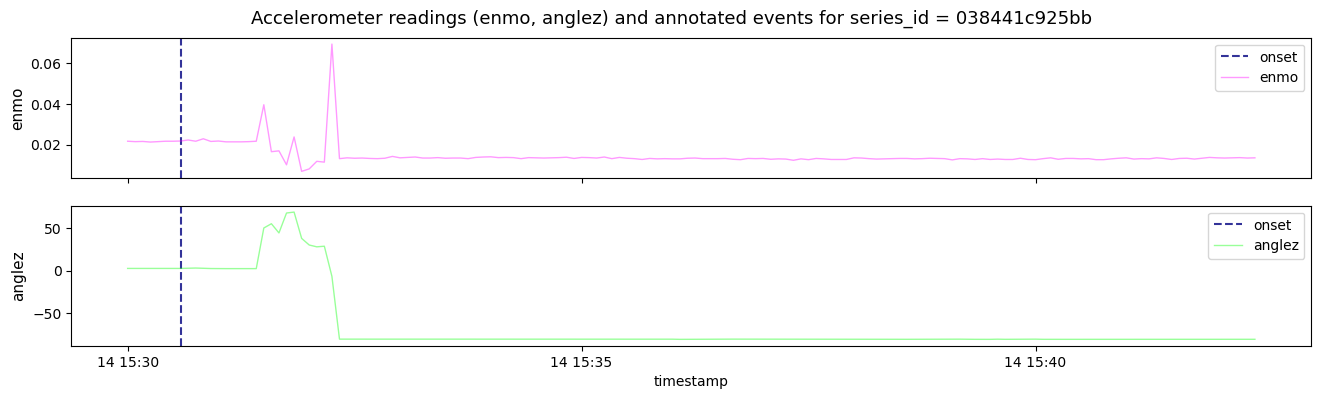

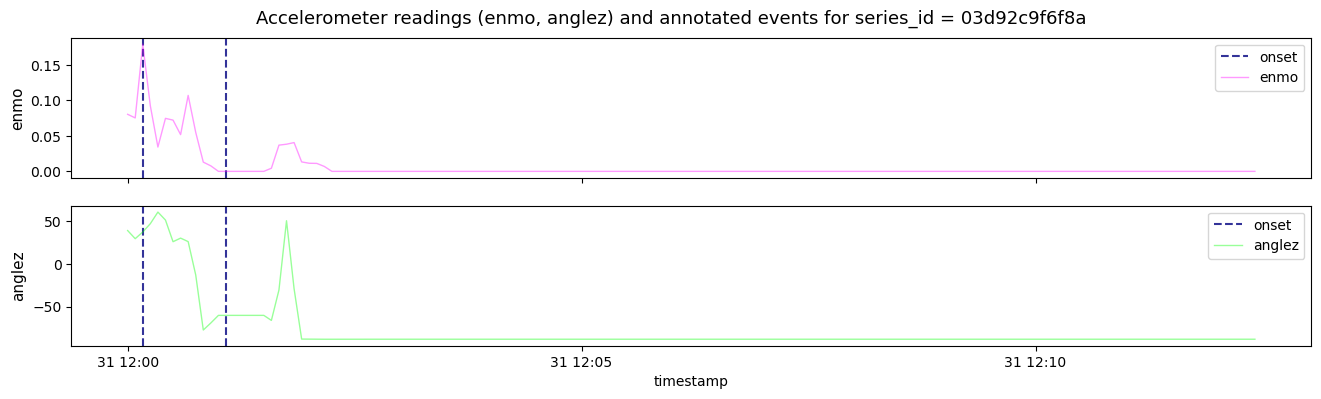

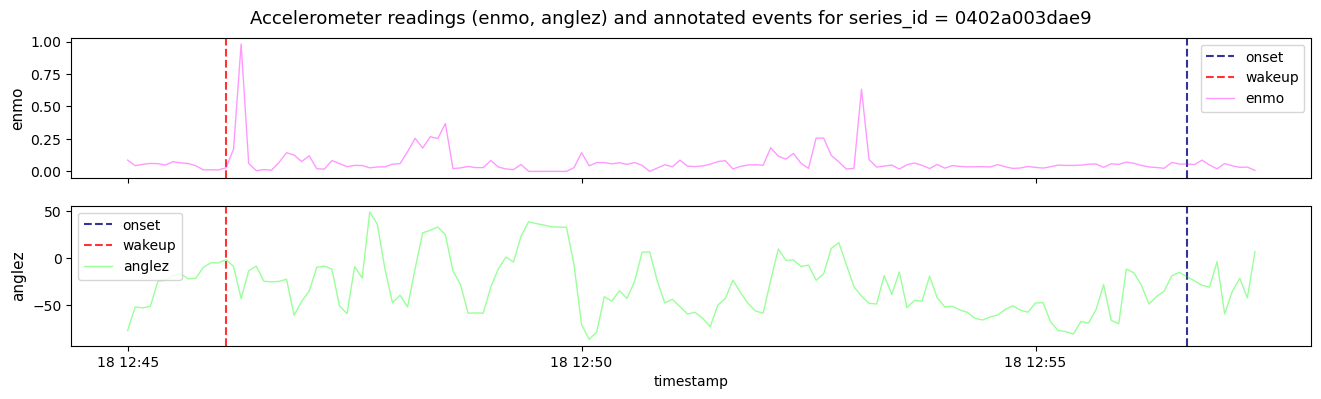

In [109]:
plot_series_and_events('038441c925bb', test_series)
plot_series_and_events('03d92c9f6f8a', test_series)
plot_series_and_events('0402a003dae9', test_series)